# Customer Default Prediction Modelling - Baseline

This notebook predicts customer defaults using `processed_train_data.csv` and `processed_test_data.csv` from the current directory. Steps include data loading, preprocessing, model training with hyperparameter tuning, evaluation, and comparison between RandomForestClassifier and a baseline LogisticRegression model. I am treating this a baseline and will try to include more models further.

In [8]:
# pip install xgboost lightgbm

In [18]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Step 1: Load Data

Load `processed_train_data.csv` and `processed_test_data.csv` from the current working directory. Check for file existence to avoid errors.

In [20]:
# Check current working directory and file existence

print(f"Current working directory: {os.getcwd()}")
train_file = "processed_train_data.csv"
test_file = "processed_test_data.csv"

if not os.path.exists(train_file) or not os.path.exists(test_file):
    raise FileNotFoundError(f"One or both files not found: {train_file}, {test_file}")

# Load datasets
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)
print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

Current working directory: /Users/thedatayogi/Documents/MS AAI
Train data shape: (70000, 82)
Test data shape: (33000, 80)


## Step 2: Preprocess Data

Handle missing values, encode categorical columns, and scale numeric features. Align train and test columns to avoid KeyError and ensure categorical encoders handle all values.

In [22]:
# Define target column
target_col = 'target'
if target_col not in train_df.columns:
    raise ValueError(f"Target column '{target_col}' not found in training data")

# Separate features and target
X_train_full = train_df.drop(columns=[target_col])
y_train_full = train_df[target_col]
X_test_final = test_df.drop(columns=[target_col], errors='ignore')

# Align train and test columns
common_cols = X_train_full.columns.intersection(X_test_final.columns)
X_train_full = X_train_full[common_cols]
X_test_final = X_test_final[common_cols]
print(f"Aligned columns: {len(common_cols)}")

# Handle missing values
numeric_cols = X_train_full.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    median_val = X_train_full[col].median()
    X_train_full[col].fillna(median_val, inplace=True)
    X_test_final[col].fillna(median_val, inplace=True)

# Encode categorical columns
label_encoders = {}
categorical_cols = X_train_full.select_dtypes(include=['object', 'bool']).columns
for col in categorical_cols:
    le = LabelEncoder()
    # Fit on combined train and test unique values to avoid unseen labels
    unique_vals = pd.concat([X_train_full[col], X_test_final[col]], axis=0).astype(str).unique()
    le.fit(unique_vals)
    X_train_full[col] = le.transform(X_train_full[col].astype(str))
    X_test_final[col] = le.transform(X_test_final[col].astype(str))
    label_encoders[col] = le

# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

# Scale features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_final)

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test_final.shape}")

Aligned columns: 80
Training set: (56000, 80), Validation set: (14000, 80), Test set: (33000, 80)


## Step 3: Train RandomForestClassifier with Hyperparameter Tuning

Train a RandomForestClassifier with GridSearchCV to find the best hyperparameters.

In [24]:
# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

# Perform GridSearchCV
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best model
rf_best = grid_search.best_estimator_
print(f"Best RandomForest parameters: {grid_search.best_params_}")
print(f"Best cross-validation ROC-AUC: {grid_search.best_score_:.4f}")

Best RandomForest parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation ROC-AUC: 0.9559


## Step 4: Train Baseline LogisticRegression

Train a LogisticRegression model as a baseline for comparison.

In [25]:
# Initialize and train LogisticRegression
lr = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

## Step 5: Evaluate Models

Evaluate both models on the validation set using ROC-AUC, F1-score, and classification report.

In [26]:
# Evaluate RandomForest
y_val_pred_rf = rf_best.predict(X_val_scaled)
y_val_proba_rf = rf_best.predict_proba(X_val_scaled)[:, 1]
print("RandomForest Validation Results:")
print(classification_report(y_val, y_val_pred_rf))
print(f"ROC AUC: {roc_auc_score(y_val, y_val_proba_rf):.4f}")
print(f"F1 Score: {f1_score(y_val, y_val_pred_rf):.4f}")

# Evaluate LogisticRegression
y_val_pred_lr = lr.predict(X_val_scaled)
y_val_proba_lr = lr.predict_proba(X_val_scaled)[:, 1]
print("\nLogisticRegression Validation Results:")
print(classification_report(y_val, y_val_pred_lr))
print(f"ROC AUC: {roc_auc_score(y_val, y_val_proba_lr):.4f}")
print(f"F1 Score: {f1_score(y_val, y_val_pred_lr):.4f}")

RandomForest Validation Results:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     10471
           1       0.85      0.76      0.80      3529

    accuracy                           0.91     14000
   macro avg       0.89      0.86      0.87     14000
weighted avg       0.91      0.91      0.91     14000

ROC AUC: 0.9633
F1 Score: 0.8049

LogisticRegression Validation Results:
              precision    recall  f1-score   support

           0       0.93      0.82      0.87     10471
           1       0.61      0.82      0.70      3529

    accuracy                           0.82     14000
   macro avg       0.77      0.82      0.79     14000
weighted avg       0.85      0.82      0.83     14000

ROC AUC: 0.8972
F1 Score: 0.6997


## Step 6: Model Comparison

Compare model performance using a bar plot of ROC-AUC and F1-score.

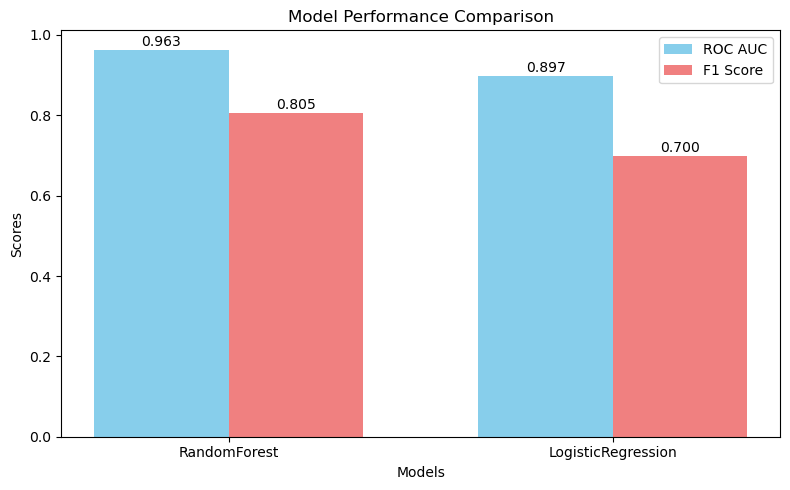

In [27]:
# Collect metrics
models = ['RandomForest', 'LogisticRegression']
roc_auc_scores = [roc_auc_score(y_val, y_val_proba_rf), roc_auc_score(y_val, y_val_proba_lr)]
f1_scores = [f1_score(y_val, y_val_pred_rf), f1_score(y_val, y_val_pred_lr)]

# Plot comparison
fig, ax = plt.subplots(figsize=(8, 5))
x = np.arange(len(models))
width = 0.35
ax.bar(x - width/2, roc_auc_scores, width, label='ROC AUC', color='skyblue')
ax.bar(x + width/2, f1_scores, width, label='F1 Score', color='lightcoral')
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
for i, (roc, f1) in enumerate(zip(roc_auc_scores, f1_scores)):
    ax.text(i - width/2, roc + 0.01, f'{roc:.3f}', ha='center')
    ax.text(i + width/2, f1 + 0.01, f'{f1:.3f}', ha='center')
plt.tight_layout()
plt.show()

## Step 7: Make Final Predictions

Use the best RandomForest model to predict on the test set and save results.

In [44]:
# Make predictions with RandomForest
predictions = rf_best.predict(X_test_scaled)
probabilities = rf_best.predict_proba(X_test_scaled)[:, 1]
print(f"Generated {len(predictions)} predictions")
print(f"Default rate: {(predictions == 1).mean():.4f}")

# Save predictions
output = pd.DataFrame({'Prediction': predictions, 'Probability': probabilities})
output.to_csv('test_predictions.csv', index=False)
print("Predictions saved to 'Baseline_test_predictions.csv'")

Generated 33000 predictions
Default rate: 0.2061
Predictions saved to 'Baseline_test_predictions.csv'
